In [2]:
# import required libraries

import numpy as np
import scipy
from scipy.io import wavfile
from numpy.fft import fft, ifft, fftshift
import librosa as lb

from scipy.signal import hamming, hann
from matplotlib import pyplot as plt
from audiolazy import lazy_lpc as lpc
from IPython import embed

# interactive plotting
plt.ion()



In [3]:
# provided functions
def est_predictor_gain(x, a, p):
    '''
    A function to compute gain of the residual signal in LP analysis.
    x:  signal 
    a: LPC coefficients
    p: order of the filter
    '''
    cor = np.correlate(x, x, mode='full')
    
    rr = cor[len(cor)//2: len(cor)//2+p+1]
    g = np.sqrt(np.sum(a*rr))
    return g

   
    
def reject_outliers(data, m=2):
    '''
    Function to reject outliers. All values beyond m standard deviations from mean are excluded
    '''
    return data[abs(data - np.mean(data)) < m * np.std(data)]

### Problem 1


------ The computed formants for i.wav and filter order 12  are : [ 322.99581976 2531.48019104 3377.3981381 ]
------ The computed formants for e.wav and filter order 12  are : [ 444.09720077 2279.95215337 3237.84672526]
------ The computed formants for o.wav and filter order 12  are : [ 487.72994836 1005.40423635 2636.2631516 ]


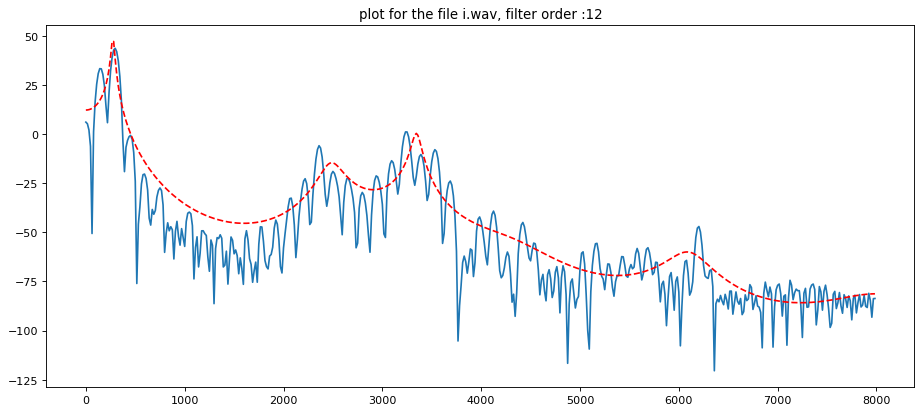

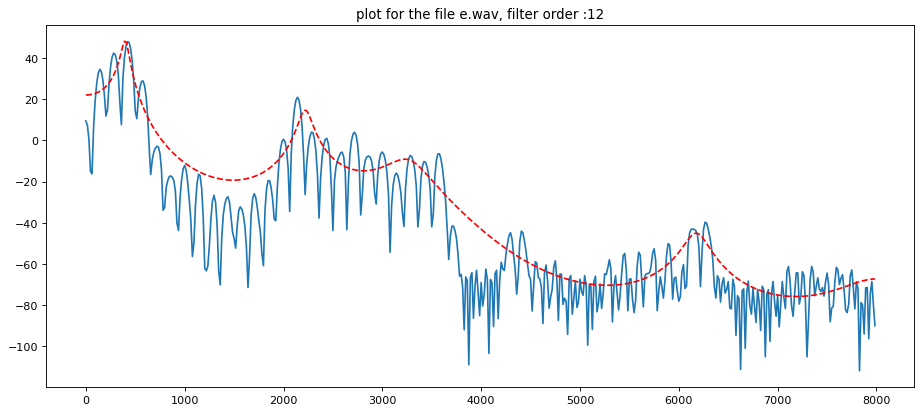

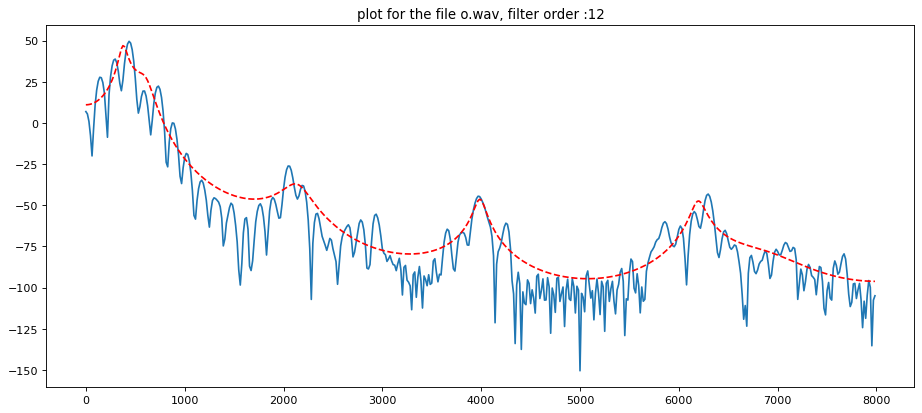

In [10]:
# provided vowel files
audiofiles = ['i.wav', 'e.wav', 'o.wav']

# A loop for all the audiofiles 
for filename in audiofiles:
    plt.figure(figsize=(14, 6), dpi= 80, facecolor='w', edgecolor='k')
        
    # read audio
    audioIn, fs=lb.load(filename, sr=None)   

    # filter order
    p = 12    # Try different values and see , e.g., 4, 12, 16, 20, 40

    # number of DFT points
    nfft = 1024

    inInd = 0
    wLen = int(0.02*fs) # 20 ms window

    win = hamming(wLen) # hamming window for example

    cnt = 0
    numframes = np.ceil( (len(audioIn)-wLen)/(wLen/2)) # number of frames     

    # choose a representative frame of the vowel
    plot_frame = int(numframes/2)  # middle of the vowel    
   
    
    formants  = []                                    # A placeholder for storing formants
    
    # The analysis loop
    while inInd< len(audioIn)-wLen:

        # audio frame
        frame = audioIn[inInd:inInd+wLen]* win

        # compute LPC and gain     
        lpc_filt = lpc.lpc.autocor(frame, p)   # gives a filter object
        lpc_coeffs = lpc_filt.numerator     # extract filter coefficients

        gain = est_predictor_gain(frame, lpc_coeffs, p)

        # Compute the freq response of the vocal tract filter
        f, h = scipy.signal.freqz(gain, lpc_coeffs, nfft//2, fs=fs)#nfft//2,

        # Compute DFT spectrum
        dft = fft(frame, nfft)
        # taking the first half
        dft = dft[0:nfft//2]
        dft = 20 *np.log10(np.abs(dft)**2) # in dB scale

        # Compute roots
        roots = np.roots(lpc_coeffs)

        #  LPC coefficients are real-valued, the roots occur in complex
        #  conjugate pairs. Retain only the roots with +ve sign for the imaginary part 
        roots = roots[np.imag(roots)>=0]

        # compute formants from roots
        angz = np.angle(roots)

        # convert to Hertz from angular frequencies
        angz = angz*(fs/(2*np.pi))

        # sort the formants in increasing order
        angz = np.sort(angz)

        # remove zero frequencies
        angz = angz[angz != 0]

        # First three formants
        formants.append(angz[:3]) 

        inInd = inInd + int(wLen/2) # frame advance

        cnt = cnt+1


        # plot the FFT spectrum and LPC spectrum here for chosen frame
        if cnt == plot_frame:            
            # plot DFT spectrum
            plt.plot(np.linspace(0, fs/2, nfft//2, endpoint = False), dft)      #,
            # plot vocal tract freq response or LP spectral envelope
            plt.plot(f, 20*np.log10(np.abs(h)**2), 'r--')
            plt.title('plot for the file ' + filename +', filter order :'+ str(p))
           

        
    formants = np.array(formants)
    print('------ The computed formants for', filename, 'and filter order', p, ' are :', np.mean(formants, 0))

       


#### 1 a) , 1b)
The LP filter obtained is inversely related to the transfer function of the vocal tract model. If A(z) is the transfer function of the LP filter, the vocal tract transfer function H(z) is given by :

$\mathbf{H(z) = \frac{g}{A(z)}}$, 

where g is the gain of the residual signal in LP analysis.

#### 1d)
While varying the filter order you will find that too low a filter order leads to a model that is not able to capture the peaks in the envelope of the dft spectrum. On the other hand, too high a order will lead to your model capturing all the spurious peaks in the spectrum. Hence the filter order needs to be chosen depending upon the signal under investigation, a good rule of thumb being 


$\mathbf{𝑝=4+\frac{𝑓𝑠}{1000}}$, 

where p and fs are model order and sampling frequency, respectively. 





## Problem2

The poles of vocal tract filter H(z) are roots of the LP model as given by the following relation,

$\mathbf{H(z) = \frac{g}{A(z)}}$.

Please note that formant extraction method used here is pretty simplistic. You can estimate the bandwidths of the extracted formants and  refine your estimates further. [Matlab link](https://www.mathworks.com/help/signal/ug/formant-estimation-with-lpc-coefficients.html)

The roots of $H(f)$, also called poles, always occur in pairs, one is the complex conjugate of the other (mirror image in the complex plane). Therefore, only half of the roots, conventionally between 0 and $pi$ (i.e. have a positive imaginary part) are selected. A polynomial of order p has p roots. Each root is a complex number, which represents a sinusoid of frequency, and damping.

Not all roots correspond to formants. If p is set to high thee will be more roots than formants.

In [6]:
B = formants[:, 0]
A = reject_outliers(B, 2)
print(np.mean(A, 0))

391.14522626180343


Text(0.5, 1.0, 'F1 formant curve after outlier rejection')

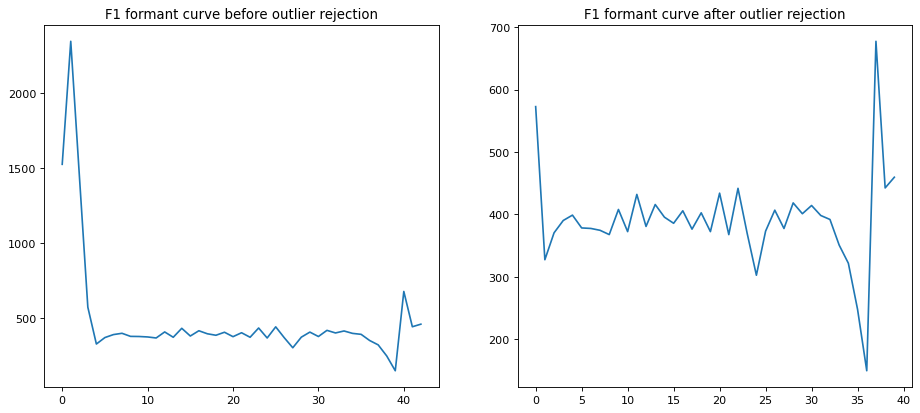

In [7]:
### Optional removal of formant outliers

# lets plot formant curve within a vowel segment

plt.figure(figsize=(14, 6), dpi= 80, facecolor='w', edgecolor='k')

plt.subplot(1, 2, 1), plt.plot(formants[:, 0])

plt.title('F1 formant curve before outlier rejection')
plt.subplot(1, 2, 2), plt.plot(reject_outliers(formants[:, 0], 1)) # remove values one standard deviation from the mean
plt.title('F1 formant curve after outlier rejection')



## Bonus problem

The concept of a time varying vocal tract having resonance frequencies at formants doesn't really apply for the given music signal. First of all, is is difficult to generate generic musical sounds since is highly dependent on the instrument used. If you run the above analysis with oboe59.wav file, you'll end up capturing some of the harmonics depending upon your filter order. The higher the filter order, the more the number of harmonics you will capture with your LP model.